## Generate Result Tables
- MCHAD
- CAC
- II
- Center Loss
- G-MCHAD
- G-Center
- G-CAC

In [28]:
import seaborn as sb
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
import pandas as pd
from os.path import join

In [29]:
sb.set()
sb.set_style("whitegrid")
sb.set_context("paper")

In [30]:
# root folder for experiment run
root = "/home/ki/projects/work/mchad/logs/multiruns/22-10:42:59/"

In [31]:
# map test cases
dataset_map = {
    "test_vs_uniformnoise": "Uniform",
    "test_vs_gaussiannoise": "Gaussian",
    "test_vs_tinycrop": "Tiny Crop",
    "test_vs_tinyresize": "Tiny Resize",
    "test_vs_lsuncrop": "LSUN Crop",
    "test_vs_lsunresize": "LSUN Resize",
    "test_vs_textures": "Texture",
}

model_map = {
    "src.models.CAC": "CAC",
    "src.models.Softmax": "Softmax",
    "src.models.MCHAD": "MCHAD",
    "src.models.Center": "Center",
    "src.models.II": "II",
    "src.models.GCAC": "G-CAC",
    "src.models.GCenter": "G-Center",
}


train_dataset_map = {
    "src.datamodules.CIFAR10DataModule": "CIFAR10",
    "src.datamodules.SVHNDataModule": "SVHN",
    "src.datamodules.CIFAR100DataModule": "CIFAR100",
}

In [32]:
def convert(df, key="Distance", task="OOD"):
    """
    Get correct metrics from dataframe
    """
    df.rename(
        inplace=True,
        columns={
            "Accuracy/test": "Accuracy",
            f"{key}/{task}/AUROC/test": "AUROC",
            f"{key}/{task}/AUPR-IN/test": "AUPR-IN",
            f"{key}/{task}/AUPR-OUT/test": "AUPR-OUT",
            f"{key}/{task}/FPR95TPR/test": "FPR95",
        },
    )

    return df

In [33]:
directories = []
directories += [f"./svhn/center/{i}" for i in range(21)]
directories += [f"./svhn/mchad/{i}" for i in range(21)]
directories += [f"./svhn/gmchad/{i}" for i in range(21)]
directories += [f"./svhn/gcenter/{i}" for i in range(21)]
directories += [f"./svhn/gcac/{i}" for i in range(21)]
directories += [f"./svhn/cac/{i}" for i in range(21)]
directories += [f"./svhn/ii/{i}" for i in range(21)]

directories += [f"./cifar100/mchad/{i}" for i in range(21)]
directories += [f"./cifar100/gmchad/{i}" for i in range(21)]
directories += [f"./cifar100/gcenter/{i}" for i in range(21)]
directories += [f"./cifar100/gcac/{i}" for i in range(21)]
directories += [f"./cifar100/cac/{i}" for i in range(21)]
directories += [f"./cifar100/ii/{i}" for i in range(21)]
directories += [f"./cifar100/center/{i}" for i in range(21)]


# del directories[directories.index("./cifar100/cac/13")]
directories += [f"./cifar10/mchad/{i}" for i in range(21)]
directories += [f"./cifar10/center/{i}" for i in range(21)]
directories += [f"./cifar10/gmchad/{i}" for i in range(21)]
directories += [f"./cifar10/gcenter/{i}" for i in range(21)]
directories += [f"./cifar10/gcac/{i}" for i in range(21)]
directories += [f"./cifar10/cac/{i}" for i in range(21)]
directories += [f"./cifar10/ii/{i}" for i in range(21)]

In [34]:


def get_training_set(datamodule):
    target = datamodule["_target_"]
    d = train_dataset_map.get(target)

    if not d:
        if target == "src.datamodules.MultiDatamodule":
            d = train_dataset_map.get(datamodule["module1"]["_target_"])

    if not d:
        print(datamodule)
    else:
        print(d)

    return d


def load(path):
    local_df = []

    df = pd.read_csv(join(path, "results.csv"))
    metrics = pd.read_csv(join(path, "csv/version_0/metrics.csv"))
    config = OmegaConf.load(join(path, "tb/version_0/hparams.yaml"))
    df["Dataset"] = get_training_set(config["datamodule"])
    df["Outliers"] = df["test_case_name"].apply(dataset_map.get)
    model = str(config["model"]["_target_"])

    if model == "src.models.CAC":
        df["Model"] = "CAC"
        df = convert(df, "Distance")
    # elif model == "src.models.SoftMax":
    #     print("EB-OOD")
    #     df_ebm = df.copy(deep=True)
    #     df_ebm["Model"] = "EB-OOD"
    #     df_emb = convert(df_ebm, "EnergyBased")
    #
    #     local_df.append(df_ebm)
    #
    #     print("Softmax")
    #     df["Model"] = "Softmax"
    #     df = convert(df, "Softmax")

    elif model == "src.models.MCHAD":
        if config["model"]["weight_oe"] == 0.0:
            # print(f"Weight OE: {config['model']['weight_oe']}")
            df["Model"] = "MCHAD"
        else:
            print(f"Weight OE: {config['model']['weight_oe']}")
            df["Model"] = "G-MCHAD"

        df = convert(df)
    elif model == "src.models.Center":
        df["Model"] = "Center"
        df = convert(df, "Distance")
    elif model == "src.models.IIModel":
        df["Model"] = "II"
        df = convert(df)
    elif model == "src.models.GCenter":
        df["Model"] = "G-Center"
        df = convert(df, key="Distance")
    elif model == "src.models.GCAC":
        df["Model"] = "G-CAC"
        df = convert(df, key="Distance")
    else:
        raise Exception(f"UNKNOWN: {model}")

    local_df.append(df)
    return config, pd.concat(local_df), metrics

In [35]:
import numpy as np

dfs = []

for d in directories:
    # filter(lambda x: "center" not in x and "cifar100/softmax/" not in x and "mchad-o" not in x, directories):
    path = join(root, d)
    config, df, metrics = load(path)
    try:
        if df is not None:
            for c in df.columns:
                if c not in ["Accuracy", "Dataset", "test_case_name"]:
                    df[df["Outliers"] == "default"][c] = np.nan

            print(path)
            print(
                f"{df['Dataset'][0]}/{df['Model'][0]} -> {df['AUROC'][1:].mean()} {len(df)}"
            )
            df = df[
                [
                    "Accuracy",
                    "AUROC",
                    "AUPR-IN",
                    "AUPR-OUT",
                    "FPR95",
                    "Dataset",
                    "Outliers",
                    "Model",
                ]
            ]
            dfs.append(df.copy())
    except Exception as e:
        print("EXCEPTION WHILE LOADING")
        print(type(e), e)
        print(df.columns)

df = pd.concat(dfs)

SVHN
/home/ki/projects/work/mchad/logs/multiruns/22-10:42:59/./svhn/center/0
SVHN/Center -> 0.9753162860870361 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/22-10:42:59/./svhn/center/1
SVHN/Center -> 0.9802993621144976 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/22-10:42:59/./svhn/center/2
SVHN/Center -> 0.9798170242990766 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/22-10:42:59/./svhn/center/3
SVHN/Center -> 0.9846113494464329 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/22-10:42:59/./svhn/center/4
SVHN/Center -> 0.976832662309919 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/22-10:42:59/./svhn/center/5
SVHN/Center -> 0.9790543743542263 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/22-10:42:59/./svhn/center/6
SVHN/Center -> 0.9728431361062186 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/22-10:42:59/./svhn/center/7
SVHN/Center -> 0.9741771050861904 8
SVHN
/home/ki/projects/work/mchad/logs/multiruns/22-10:42:59/./svhn/center/8
SVHN/Center -> 0.971

In [36]:
df["AUROC"] = df["AUROC"].apply(lambda x: x * 100)
df["AUPR-IN"] = df["AUPR-IN"].apply(lambda x: x * 100)
df["AUPR-OUT"] = df["AUPR-OUT"].apply(lambda x: x * 100)
df["FPR95"] = df["FPR95"].apply(lambda x: x * 100)
df["Accuracy"] = df["Accuracy"].apply(lambda x: x * 100)

In [37]:
# , "Tiny Crop", "LSUN Crop"
# df = df[df["Outliers"].isin(["Texture", "Tiny Resize", "LSUN Resize", "Uniform", "Gaussian"])]
df = df.set_index(["Dataset", "Outliers", "Model"]).dropna()


In [38]:
from itertools import product
datasets = ["SVHN", "CIFAR10", "CIFAR100"]
# models = ["CAC", "II", "Center", "Softmax", "EB-OOD", "MCHAD", "G-MCHAD"]
models = ["MCHAD", "II", "CAC", "Center", "G-MCHAD", "G-Center", "G-CAC"]

t =  df.reset_index().groupby(by=["Dataset", "Model"]).agg(
        {
            "Accuracy": ["mean", "sem"],
            "AUROC": ["mean", "sem"],
            "AUPR-IN": ["mean", "sem"],
            "AUPR-OUT": ["mean", "sem"],
            "FPR95": ["mean", "sem"],
        }
    ).reindex(list(product(datasets, models)))

s = t.to_latex(
        float_format="%.2f",
        multirow=True,
        escape=False,
        label="tab:results",
        # bold_rows="True",
    )

repl = {
    "mean": "Mean",
    "sem": "$\\pm \sigma_{\\bar{x}}$",
    " MCHAD": " \\textbf{MCHAD (ours)}",
    "G-MCHAD": "\\textbf{G-MCHAD (ours)}",
    "G-Center": "\\textbf{G-Center (ours)}",
    "G-CAC": "\\textbf{G-CAC (ours)}",
}

for k, v in repl.items():
    s = s.replace(k, v)

print(s)

\begin{table}
\centering
\label{tab:results}
\begin{tabular}{llrrrrrrrrrr}
\toprule
         &       & \multicolumn{2}{l}{Accuracy} & \multicolumn{2}{l}{AUROC} & \multicolumn{2}{l}{AUPR-IN} & \multicolumn{2}{l}{AUPR-OUT} & \multicolumn{2}{l}{FPR95} \\
         &       &     Mean &  $\pm \sigma_{\bar{x}}$ &  Mean &  $\pm \sigma_{\bar{x}}$ &    Mean &  $\pm \sigma_{\bar{x}}$ &     Mean &  $\pm \sigma_{\bar{x}}$ &  Mean &  $\pm \sigma_{\bar{x}}$ \\
Dataset & Model &          &      &       &      &         &      &          &      &       &      \\
\midrule
\multirow{7}{*}{SVHN} & \textbf{MCHAD (ours)} &    95.83 & 0.01 & 99.23 & 0.05 &   97.21 & 0.17 &    99.74 & 0.02 &  3.12 & 0.19 \\
         & II &    10.93 & 0.15 & 51.92 & 1.40 &   30.18 & 1.07 &    75.78 & 0.89 & 83.76 & 1.93 \\
         & CAC &    94.55 & 0.03 & 95.86 & 0.19 &   88.90 & 0.47 &    97.60 & 0.15 & 15.72 & 1.18 \\
         & Center &    96.12 & 0.01 & 97.85 & 0.11 &   93.87 & 0.25 &    98.84 & 0.08 &  6.68 & 0.33 \\
  

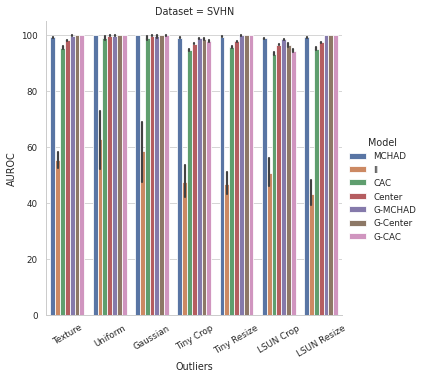

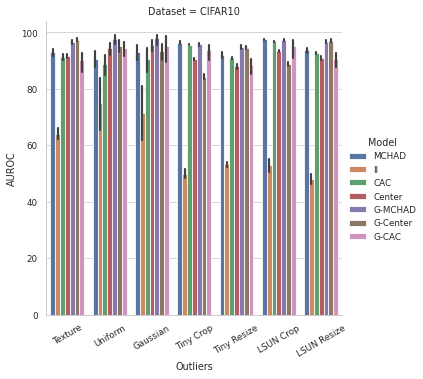

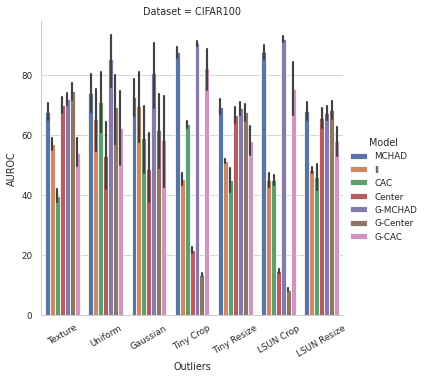

In [43]:
methods = ["MCHAD", "II", "CAC", "Center", "G-MCHAD", "G-Center", "G-CAC"]
# ,
for dataset in ["SVHN", "CIFAR10", "CIFAR100"]:
    g = sb.catplot(
        data=df.reset_index()[df.reset_index()["Dataset"] == dataset],
        x="Outliers",
        y="AUROC",
        kind="bar",
        hue="Model",
        col="Dataset",
        hue_order=methods
    )
    g.set_xticklabels(rotation=30)
    plt.savefig(f"out/single-auroc-{dataset}.png", dpi=300)
    plt.show()

In [40]:
tmp = df.reset_index().copy()
# tmp = tmp[(tmp["Model"] == "MCHAD") | (tmp["Model"] == "G-MCHAD")| (tmp["Model"] == "G-CAC") | (tmp["Model"] == "G-Center")]

print(
    tmp
    .groupby(by=["Dataset", "Model"])
    .agg(
        {
            "Accuracy": ["mean", "sem"],
            "AUROC": ["mean", "sem"],
            "AUPR-IN": ["mean", "sem"],
            "AUPR-OUT": ["mean", "sem"],
            "FPR95": ["mean", "sem"],
        }
    )
    .to_html(
        float_format="%.2f",
        escape=False,
    )
)


<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th></th>
      <th colspan="2" halign="left">Accuracy</th>
      <th colspan="2" halign="left">AUROC</th>
      <th colspan="2" halign="left">AUPR-IN</th>
      <th colspan="2" halign="left">AUPR-OUT</th>
      <th colspan="2" halign="left">FPR95</th>
    </tr>
    <tr>
      <th></th>
      <th></th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
      <th>mean</th>
      <th>sem</th>
    </tr>
    <tr>
      <th>Dataset</th>
      <th>Model</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th rowspan="7" valign="top">CIFAR10</th>
      <th>CAC</th>
      <td>95.13</td>
      <td>0.01</td>
      <td>92.43</td>
      <td>0.47</td>
      <td>8

In [41]:
tmp.groupby(by=["Dataset", "Model"]).agg(
    {
        "Accuracy": ["mean", "sem"],
        "AUROC": ["mean", "sem"],
        "AUPR-IN": ["mean", "sem"],
        "AUPR-OUT": ["mean", "sem"],
        "FPR95": ["mean", "sem"],
    }
)

Accuracy                AUROC              AUPR-IN  \
                        mean       sem       mean       sem       mean   
Dataset  Model                                                           
CIFAR10  CAC       95.126190  0.011360  92.429240  0.466113  87.863033   
         Center    94.426666  0.010246  92.118288  0.311789  88.532800   
         G-CAC     91.993333  1.113901  92.540322  0.718297  89.648925   
         G-Center  94.300952  0.011530  93.003361  0.463421  88.688589   
         G-MCHAD   94.710000  0.010663  96.692620  0.220522  94.337611   
         II        27.921429  0.173173  59.278200  1.307609  57.969902   
         MCHAD     94.757619  0.016054  93.726808  0.376774  89.017105   
CIFAR100 CAC       28.782857  0.166268  52.734350  1.485742  50.581708   
         Center    75.344285  0.020017  48.523927  2.130344  49.152749   
         G-CAC      6.568571  0.334582  63.982069  1.955214  62.563930   
         G-Center  70.812381  0.053688  51.842993  2.528156  53.619570   
         G-MCHAD   75.693810  0.028327  79.545431  1.325210  75.300558   
         II         5.740000  0.070712  54.488083  1.375266  53.261342   
         MCHAD     76.097619  0.027309  75.286825  1.030174  66.540188   
SVHN     CAC       94.553955  0.029587  95.860497  0.194658  88.895948   
         Center    96.121258  0.008670  97.847164  0.108699  93.867375   
         G-CAC     94.254690  0.030918  98.777110  0.176847  97.735924   
         G-Center  95.862053  0.010640  99.225532  0.125236  98.001638   
         G-MCHAD   95.694128  0.008881  99.307894  0.062691  96.827780   
         II        10.932698  0.152262  51.917934  1.404765  30.179464   
         MCHAD     95.826565  0.008983  99.231108  0.045847  97.205604   

                              AUPR-OUT                FPR95            
                        sem       mean       sem       mean       sem  
Dataset  Model                                                         
CIFAR10  CAC       0.794457  94.546703  0.283855  20.061837  0.860877  
         Center    0.480032  92.278728  0.385590  31.414762  1.645655  
         G-CAC     0.854550  93.716704  0.679478  22.281905  1.641423  
         G-Center  0.789205  94.536871  0.369842  20.280272  1.141889  
         G-MCHAD   0.429609  97.592328  0.148351  10.254490  0.531105  
         II        1.174104  61.449056  1.336135  82.214490  2.064636  
         MCHAD     0.745258  95.562658  0.247881  16.739592  0.862430  
CIFAR100 CAC       1.363971  60.616230  1.272989  79.106803  2.068803  
         Center    1.206738  60.458194  1.652207  77.849048  1.730044  
         G-CAC     1.746153  69.726132  1.520075  67.655306  2.665000  
         G-Center  1.499055  62.829022  1.891454  74.257211  2.125950  
         G-MCHAD   1.388870  83.255710  1.083890  49.315986  2.450309  
         II        1.229444  57.717453  1.320986  85.468708  1.946847  
         MCHAD     1.228687  81.578280  0.779884  52.375102  1.820013  
SVHN     CAC       0.471979  97.604768  0.147711  15.721885  1.182930  
         Center    0.247690  98.843399  0.077949   6.675902  0.327091  
         G-CAC     0.326153  99.149438  0.131507   5.505965  0.939661  
         G-Center  0.327515  99.636093  0.061982   2.915982  0.459609  
         G-MCHAD   0.322911  99.774432  0.020720   2.249717  0.191324  
         II        1.070628  75.783743  0.891900  83.762502  1.926307  
         MCHAD     0.166426  99.741119  0.016079   3.119839  0.192758

In [42]:
from scipy.stats import ttest_ind

tmp = df.reset_index().copy()
# tmp = tmp[(tmp["Model"] == "MCHAD") | (tmp["Model"] == "G-MCHAD")]

for metric in ["Accuracy", "AUROC", "AUPR-IN", "AUPR-OUT", "FPR95"]:
    for dataset in ["SVHN", "CIFAR10", "CIFAR100"]:
        a = tmp[(tmp["Model"] == "CAC") & (tmp["Dataset"] == dataset)][metric]
        b = tmp[(tmp["Model"] == "MCHAD") & (tmp["Dataset"]== dataset)][metric]
        stat, p = ttest_ind(a,b, equal_var=False)
        print(f"{metric} {dataset} -> {p < 0.05} ")

Accuracy SVHN -> True 
Accuracy CIFAR10 -> True 
Accuracy CIFAR100 -> True 
AUROC SVHN -> True 
AUROC CIFAR10 -> True 
AUROC CIFAR100 -> True 
AUPR-IN SVHN -> True 
AUPR-IN CIFAR10 -> False 
AUPR-IN CIFAR100 -> True 
AUPR-OUT SVHN -> True 
AUPR-OUT CIFAR10 -> True 
AUPR-OUT CIFAR100 -> True 
FPR95 SVHN -> True 
FPR95 CIFAR10 -> True 
FPR95 CIFAR100 -> True 
